# Test & Validation - Preprocessed Features

**Cel:** Sprawdzić czy zapisane cechy działają i jak ich używać

**Co testujemy:**
1. Ładowanie danych z Delta Lake
2. Walidacja cech
3. Przykłady użycia
4. Preview dla ML models

---

In [1]:
# Imports
import sys
sys.path.append('../')

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, min as _min, max as _max
from config.spark_config import SparkConfig

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## 1. Start Spark Session

In [2]:
spark = SparkConfig.get_spark_session("BlackFriday-TestFeatures")
print("✓ Spark ready!")

✓ Windows: HADOOP_HOME set to C:\Users\usate\PycharmProjects\BlackFriday\hadoop
  Note: If you encounter permission errors, download winutils.exe
  from https://github.com/steveloughran/winutils and place in hadoop/bin/
Spark Session Created: BlackFriday-TestFeatures
Spark Version: 3.5.3
Master: local[*]
App Name: BlackFriday-TestFeatures
✓ Spark ready!


## 2. Ładowanie Danych z Delta Lake

**Jak załadować preprocessed features:**

In [3]:
# Load main features dataset
df_features = spark.read.format("delta").load("../data/processed/delta/features")

print(f"\n✓ Loaded: {df_features.count():,} rows x {len(df_features.columns)} columns")
print("\nSchema:")
df_features.printSchema()


✓ Loaded: 550,068 rows x 44 columns

Schema:
root
 |-- User_ID: integer (nullable = true)
 |-- Product_ID: string (nullable = true)
 |-- Purchase: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- Occupation: integer (nullable = true)
 |-- City_Category: string (nullable = true)
 |-- Stay_In_Current_City_Years: string (nullable = true)
 |-- Marital_Status: integer (nullable = true)
 |-- Product_Category_1: integer (nullable = true)
 |-- Product_Category_2: integer (nullable = true)
 |-- Product_Category_3: integer (nullable = true)
 |-- user_purchase_count: long (nullable = true)
 |-- user_total_spent: long (nullable = true)
 |-- user_avg_purchase: double (nullable = true)
 |-- user_min_purchase: integer (nullable = true)
 |-- user_max_purchase: integer (nullable = true)
 |-- user_std_purchase: double (nullable = true)
 |-- user_unique_products: long (nullable = true)
 |-- user_unique_categories: long (nullable = true)
 |-- user_pu

In [4]:
# Load individual feature sets
user_features = spark.read.format("delta").load("../data/processed/delta/user_features")
product_features = spark.read.format("delta").load("../data/processed/delta/product_features")
category_features = spark.read.format("delta").load("../data/processed/delta/category_features")

print(f"\n✓ User features: {user_features.count():,} users")
print(f"✓ Product features: {product_features.count():,} products")
print(f"✓ Category features: {category_features.count()} categories")


✓ User features: 5,891 users
✓ Product features: 3,631 products
✓ Category features: 20 categories


## 3. Walidacja Danych

**Sprawdzamy czy cechy zostały poprawnie utworzone:**

In [5]:
# Check for nulls
print("\n" + "="*60)
print("WALIDACJA: NULL VALUES")
print("="*60)

null_counts = df_features.select([
    count(col(c).isNull().cast("int")).alias(c) 
    for c in df_features.columns[:15]  # First 15 cols
])

null_counts.show()


WALIDACJA: NULL VALUES
+-------+----------+--------+------+------+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+-------------------+----------------+-----------------+
|User_ID|Product_ID|Purchase|Gender|   Age|Occupation|City_Category|Stay_In_Current_City_Years|Marital_Status|Product_Category_1|Product_Category_2|Product_Category_3|user_purchase_count|user_total_spent|user_avg_purchase|
+-------+----------+--------+------+------+----------+-------------+--------------------------+--------------+------------------+------------------+------------------+-------------------+----------------+-----------------+
| 550068|    550068|  550068|550068|550068|    550068|       550068|                    550068|        550068|            550068|            550068|            550068|             550068|          550068|           550068|
+-------+----------+--------+------+------+----------+-------------+----------------

In [6]:
# Check feature ranges
print("\n" + "="*60)
print("WALIDACJA: FEATURE RANGES")
print("="*60)

feature_stats = df_features.select(
    "Purchase",
    "user_avg_purchase",
    "product_popularity_score",
    "rfm_score",
    "is_high_value_customer"
).describe()

feature_stats.show()


WALIDACJA: FEATURE RANGES
+-------+-----------------+------------------+------------------------+--------------------+----------------------+
|summary|         Purchase| user_avg_purchase|product_popularity_score|           rfm_score|is_high_value_customer|
+-------+-----------------+------------------+------------------------+--------------------+----------------------+
|  count|           550068|            550068|                  550068|              550068|                550068|
|   mean|9263.968712959126| 9263.968712959115|     0.18545974861790573|  0.7600518627960847|     0.563130376607983|
| stddev|5023.065393820581|1619.5105670471587|     0.18423307668406763| 0.23262711582228435|    0.4959989947510414|
|    min|               12| 2318.733333333333|                     0.0|1.697792869269949...|                     0|
|    max|            23961|18577.893617021276|      0.9606060606060606|  0.9999151103565365|                     1|
+-------+-----------------+------------------

In [7]:
# Validate RFM scores (should be 0-1)
print("\n" + "="*60)
print("WALIDACJA: RFM SCORES (powinny być 0-1)")
print("="*60)

rfm_validation = df_features.select(
    _min("rfm_score").alias("rfm_min"),
    _max("rfm_score").alias("rfm_max"),
    avg("rfm_score").alias("rfm_avg")
).collect()[0]

print(f"RFM Score range: {rfm_validation['rfm_min']:.4f} - {rfm_validation['rfm_max']:.4f}")
print(f"RFM Score average: {rfm_validation['rfm_avg']:.4f}")

if 0 <= rfm_validation['rfm_min'] <= rfm_validation['rfm_max'] <= 1:
    print("✓ RFM scores are valid (0-1 range)")
else:
    print("⚠️  RFM scores out of expected range!")


WALIDACJA: RFM SCORES (powinny być 0-1)
RFM Score range: 0.0002 - 0.9999
RFM Score average: 0.7601
✓ RFM scores are valid (0-1 range)


## 4. Przykłady Użycia Cech

### 4.1 Znajdź VIP Customers (High RFM Score)

In [8]:
# Find VIP customers (top 10% by RFM)
vip_customers = user_features.filter(col("rfm_score") >= 0.9).orderBy(col("rfm_score").desc())

print(f"\n✓ VIP Customers (RFM ≥ 0.9): {vip_customers.count():,}")
print("\nTop 10 VIP Customers:")
vip_customers.select(
    "User_ID",
    "user_purchase_count",
    "user_total_spent",
    "rfm_score"
).show(10)


✓ VIP Customers (RFM ≥ 0.9): 581

Top 10 VIP Customers:
+-------+-------------------+----------------+------------------+
|User_ID|user_purchase_count|user_total_spent|         rfm_score|
+-------+-------------------+----------------+------------------+
|1001680|               1026|         8699596|0.9999151103565365|
|1004277|                979|        10536909|0.9999151103565365|
|1001941|                898|         6817493|0.9995755517826825|
|1001181|                862|         6387961| 0.998981324278438|
|1002909|                718|         7577756| 0.998981324278438|
|1001015|                740|         6511314| 0.998811544991511|
|1005831|                727|         6512433|0.9987266553480475|
|1003618|                767|         5962012|0.9983870967741936|
|1000424|                694|         6573609|  0.99830220713073|
|1003391|                698|         6477160|0.9980475382003395|
+-------+-------------------+----------------+------------------+
only showing top 10

In [9]:
# VIP Statistics
vip_stats = vip_customers.select(
    count("*").alias("vip_count"),
    avg("user_total_spent").alias("avg_lifetime_value"),
    avg("user_purchase_count").alias("avg_purchases")
).collect()[0]

print("\n" + "="*60)
print("VIP CUSTOMER STATISTICS")
print("="*60)
print(f"Total VIP customers: {vip_stats['vip_count']:,}")
print(f"Average Lifetime Value: ${vip_stats['avg_lifetime_value']:,.2f}")
print(f"Average Purchases per VIP: {vip_stats['avg_purchases']:.1f}")


VIP CUSTOMER STATISTICS
Total VIP customers: 581
Average Lifetime Value: $3,124,690.26
Average Purchases per VIP: 353.5


### 4.2 Analiza Bestsellers (Product Popularity)

In [10]:
# Top 10 bestselling products
bestsellers = product_features.orderBy(col("product_purchase_count").desc()).limit(10)

print("\n" + "="*60)
print("TOP 10 BESTSELLERS")
print("="*60)

bestsellers.select(
    "Product_ID",
    "product_purchase_count",
    "product_avg_price",
    "product_total_revenue",
    "product_popularity_score"
).show(10, truncate=False)


TOP 10 BESTSELLERS
+----------+----------------------+------------------+---------------------+------------------------+
|Product_ID|product_purchase_count|product_avg_price |product_total_revenue|product_popularity_score|
+----------+----------------------+------------------+---------------------+------------------------+
|P00265242 |1880                  |7534.848404255319 |14165515             |0.0                     |
|P00025442 |1615                  |17334.46811145511 |27995166             |2.754820936639118E-4    |
|P00110742 |1612                  |16577.11476426799 |26722309             |5.509641873278236E-4    |
|P00112142 |1562                  |15503.204865556978|24216006             |8.264462809917355E-4    |
|P00057642 |1470                  |15716.176870748299|23102780             |0.0011019283746556473   |
|P00184942 |1440                  |16899.227083333335|24334887             |0.0013774104683195593   |
|P00046742 |1438                  |14709.931849791377|21152882

### 4.3 Segmentacja Klientów (RFM Based)

In [11]:
# Segment customers by RFM score
from pyspark.sql.functions import when

segmented = user_features.withColumn(
    "segment",
    when(col("rfm_score") >= 0.8, "Champions")
    .when(col("rfm_score") >= 0.5, "Loyal")
    .when(col("rfm_score") >= 0.3, "Potential")
    .otherwise("At Risk")
)

# Count per segment
segment_counts = segmented.groupBy("segment").agg(
    count("*").alias("customer_count"),
    avg("user_total_spent").alias("avg_clv"),
    avg("user_purchase_count").alias("avg_purchases")
).orderBy(col("avg_clv").desc())

print("\n" + "="*60)
print("CUSTOMER SEGMENTATION (RFM)")
print("="*60)
segment_counts.show()


CUSTOMER SEGMENTATION (RFM)
+---------+--------------+------------------+------------------+
|  segment|customer_count|           avg_clv|     avg_purchases|
+---------+--------------+------------------+------------------+
|Champions|          1160| 2403618.048275862| 267.0344827586207|
|    Loyal|          1765| 861273.4243626063| 89.03456090651558|
|Potential|          1174|396975.48637137987| 41.20954003407155|
|  At Risk|          1792|179363.27622767858|19.409598214285715|
+---------+--------------+------------------+------------------+



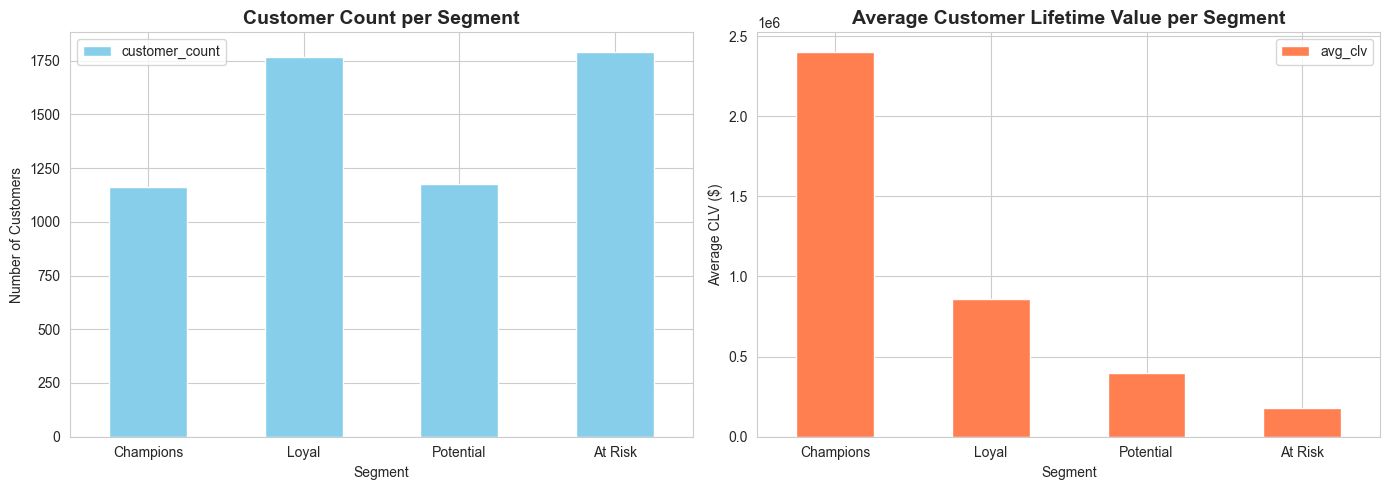

In [12]:
# Visualize segments
segments_pd = segment_counts.toPandas()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Customer count per segment
segments_pd.plot(kind='bar', x='segment', y='customer_count', ax=ax1, color='skyblue')
ax1.set_title('Customer Count per Segment', fontsize=14, fontweight='bold')
ax1.set_xlabel('Segment')
ax1.set_ylabel('Number of Customers')
ax1.tick_params(axis='x', rotation=0)

# Average CLV per segment
segments_pd.plot(kind='bar', x='segment', y='avg_clv', ax=ax2, color='coral')
ax2.set_title('Average Customer Lifetime Value per Segment', fontsize=14, fontweight='bold')
ax2.set_xlabel('Segment')
ax2.set_ylabel('Average CLV ($)')
ax2.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## 5. Preview dla ML Models

### 5.1 Dane Gotowe do Regression (Purchase Prediction)

In [13]:
# Select features for regression model
ml_data = df_features.select(
    "Purchase",  # Target
    "features",  # Feature vector
    "scaled_features",  # Scaled features
    # For interpretation
    "user_avg_purchase",
    "product_avg_price",
    "rfm_score"
)

print("\n" + "="*60)
print("ML-READY DATA (Regression)")
print("="*60)
print(f"Dataset: {ml_data.count():,} rows")
print("\nSample:")
ml_data.show(5)


ML-READY DATA (Regression)
Dataset: 550,068 rows

Sample:
+--------+--------------------+--------------------+------------------+------------------+-------------------+
|Purchase|            features|     scaled_features| user_avg_purchase| product_avg_price|          rfm_score|
+--------+--------------------+--------------------+------------------+------------------+-------------------+
|   15563|[1.0,6.0,2.0,4.0,...|[2.31908001899471...|        5453.90625|        11127.6875| 0.7491511035653651|
|   18995|[0.0,6.0,2.0,0.0,...|[0.0,3.6854800848...|12692.093023255815|16255.099494097807| 0.4692699490662139|
|    4498|[1.0,6.0,2.0,4.0,...|[2.31908001899471...|        5453.90625|14287.093596059114| 0.7491511035653651|
|    3022|[0.0,6.0,2.0,4.0,...|[0.0,3.6854800848...| 9702.305732484076| 7872.603174603175| 0.8262308998302207|
|   13650|[1.0,6.0,2.0,1.0,...|[2.31908001899471...| 9545.514285714286|11143.642361111111|0.35407470288624787|
+--------+--------------------+--------------------+-

In [ ]:
# Split for training
train, test = ml_data.randomSplit([0.8, 0.2], seed=42)

print(f"\n✓ Train set: {train.count():,} rows")
print(f"✓ Test set: {test.count():,} rows")
print("\n🎯 Ready for ML model training!")

### 5.2 Dane dla Clustering (Customer Segmentation)

In [ ]:
# Select features for clustering
from pyspark.ml.feature import VectorAssembler, StandardScaler

clustering_features = [
    "user_purchase_count",
    "user_total_spent",
    "user_avg_purchase",
    "user_unique_products",
    "rfm_score"
]

# Prepare for K-Means
assembler = VectorAssembler(inputCols=clustering_features, outputCol="cluster_features")
clustering_data = assembler.transform(user_features)

# Scale features
scaler = StandardScaler(inputCol="cluster_features", outputCol="scaled_cluster_features")
scaler_model = scaler.fit(clustering_data)
clustering_data_scaled = scaler_model.transform(clustering_data)

print("\n" + "="*60)
print("ML-READY DATA (Clustering)")
print("="*60)
print(f"Dataset: {clustering_data_scaled.count():,} customers")
print(f"Features: {len(clustering_features)}")
print("\n🎯 Ready for K-Means clustering!")

### 5.3 Dane dla Recommendation System (ALS)

In [ ]:
# Prepare User-Product interaction matrix
interactions = df_features.select(
    "User_ID",
    "Product_ID",
    "Purchase"  # Będziemy normalize to rating
).groupBy("User_ID", "Product_ID").agg(
    count("*").alias("purchase_count"),
    avg("Purchase").alias("avg_purchase")
)

print("\n" + "="*60)
print("ML-READY DATA (Recommendations)")
print("="*60)
print(f"Interactions: {interactions.count():,}")
print(f"Unique users: {interactions.select('User_ID').distinct().count():,}")
print(f"Unique products: {interactions.select('Product_ID').distinct().count():,}")
print("\n🎯 Ready for ALS model!")

interactions.show(5)

## 6. Feature Importance Preview

In [ ]:
# Correlation with target (Purchase)
correlations_pd = df_features.select(
    "Purchase",
    "user_avg_purchase",
    "product_avg_price",
    "category_avg_price",
    "product_popularity_score",
    "rfm_score"
).toPandas()

# Compute correlation matrix
corr_matrix = correlations_pd.corr()

# Visualize
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".3f", cmap='coolwarm', center=0)
plt.title('Feature Correlation with Purchase', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print correlations with target
print("\n" + "="*60)
print("CORRELATION WITH TARGET (Purchase)")
print("="*60)
print(corr_matrix['Purchase'].sort_values(ascending=False))

## 7. Summary & Next Steps

In [ ]:
print("\n" + "="*60)
print("✅ FEATURE VALIDATION COMPLETE")
print("="*60)

print("\n✓ Validated:")
print("  - Delta Lake loading works")
print("  - Features are correctly engineered")
print("  - RFM scores in valid range (0-1)")
print("  - Data ready for ML models")

print("\n🎯 Next Steps:")
print("  1. Build Regression Model (Purchase Prediction)")
print("  2. Build Clustering Model (Customer Segmentation)")
print("  3. Build Recommendation System (ALS)")
print("  4. Model Evaluation & Tuning")

print("\n📊 Use Cases Ready:")
print("  - VIP Customer Identification")
print("  - Bestseller Analysis")
print("  - Customer Segmentation")
print("  - Predictive Analytics")
print("  - Recommendation Engine")

print("\n" + "="*60)

In [ ]:
# Stop Spark
# spark.stop()